In [1]:
import pyscf
from pyscf import gto,dft,scf

import torch
torch.set_default_dtype(torch.double)
import pyscf
from pyscf import gto,dft,scf

import numpy as np
import scipy
from ase import Atoms
from ase.io import read
from dpyscf.net import * 
from dpyscf.torch_routines import * 
from dpyscf.utils import *
from dpyscf.losses import *
from pyscf.cc import CCSD
from functools import partial
from ase.units import Bohr
%pylab inline
DEVICE='cpu'

Populating the interactive namespace from numpy and matplotlib


/gpfs/home/smdick/miniconda3/envs/torch/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['eig', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
def get_gamma(rho, s):
    return (s*2*(3*np.pi**2)**(1/3)*rho**(4/3))**2
    
def get_tau(rho, gamma, alpha):
    uniform_factor = (3/10)*(3*np.pi**2)**(2/3)
    return (gamma/(8*rho))+(uniform_factor*rho**(5/3))*alpha

def unpol_input(rho, gamma, tau):
    return .5*rho, .5*rho, 0.25*gamma, 0.25*gamma, 0.25*gamma, 0*tau, 0*tau, 0.5*tau, 0.5*tau

In [3]:
def plot_fxc(models, rs = [0.1, 1, 5], s_range=[0, 3], alpha_range=None, only = None):
    
    if only is not None:
        saved_models = {}
        for model_name in models:
            gm = models[model_name].grid_models
            saved_models[model_name] = gm
            models[model_name].grid_models = gm[only:only+1]
    if alpha_range is None:
        alpha_range_= [1]
    else:
        alpha_range_= alpha_range
    idx = 0
    for  _, rs_val in enumerate(rs):
        for alpha in alpha_range_:
            rho_val = 3/(4*np.pi*rs_val**3)
            s = torch.linspace(s_range[0], s_range[1],100)
            rho = torch.Tensor([rho_val]*len(s))
            gamma = get_gamma(rho, s)
            tau = get_tau(rho, gamma, alpha)

            inp = torch.stack(unpol_input(rho, gamma, tau),dim=-1)
            for model_name, ls in zip(models,['-','--',':','-.']):

                if ls == '-' and len(rs) > 1: 
                    l = '$r_s = ${}'.format(rs_val)
                elif ls == '-' and len(alpha_range_) > 1:
                    if alpha_range is not None:
                        l = ' $\\alpha = $ {}'.format(alpha)
                else:
                    l = ''
                    
                ax = plot(s, models[model_name].eval_grid_models(inp).squeeze().detach().numpy()/models[model_name].heg_model(rho).squeeze(),
                     label = l, color='C{}'.format(idx),ls = ls)
            idx+=1
            
    for model_name, ls in zip(models,['-','--',':','-.']):  
        c = 'gray' if len(rs) > 1 or len(alpha_range_) > 1 else 'C0'
        plot([],label=model_name,color=c,ls=ls)

    ylabel('$F_{xc}$ (a.u.)')
    xlabel('s')
    legend()
    
    if only is not None:
        for model_name in models:
            models[model_name].grid_models = saved_models[model_name]

def plot_x_and_c(models, rs = [0.1, 1, 5], s_range=[0, 3], alpha_range=None):
    figsize(16,4)
    subplot(1,3,1)
    alpha_limited = [alpha_range[1]] if alpha_range is not None else None
    plot_fxc(models, rs, s_range, alpha_range=alpha_limited)
    subplot(1,3,2)
    plot_fxc(models, rs=[1], s_range=s_range, only = 0,alpha_range=alpha_range)
    ylabel('$F_{x}$ (a.u.)')
    subplot(1,3,3)
    plot_fxc(models, rs, s_range, only = 1,alpha_range=alpha_limited)
    ylabel('$F_{c}$ (a.u.)')

## GGA-KSR (NN)

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe/


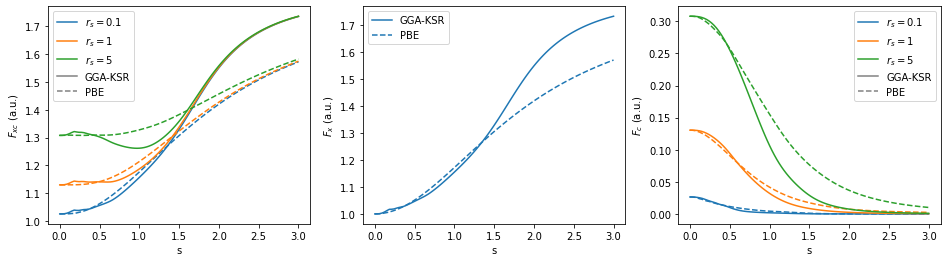

In [18]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga/2021-01-26_18:55:27.336476_val.chkpt', ueg_limit=True).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base})

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe/


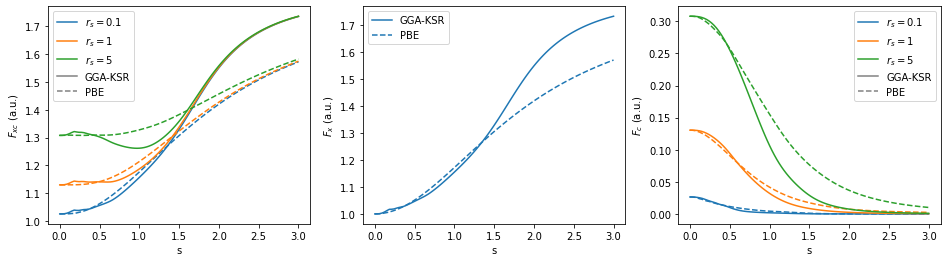

In [4]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga/2021-01-26_18:55:27.336476_val.chkpt', ueg_limit=True).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base})

## GGA-KSR (polynomial)

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe_pol/


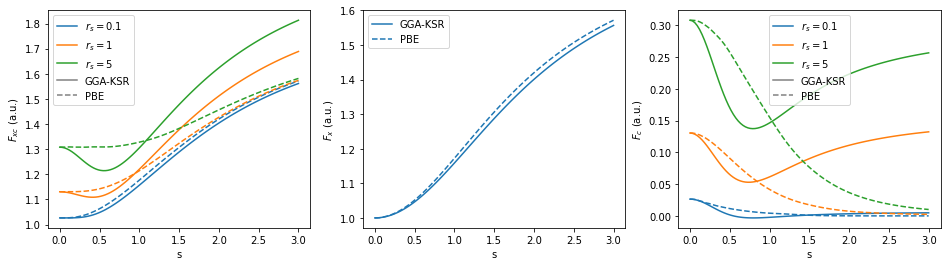

In [8]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe_pol/',path='../exp/log_gga_pol/2021-01-31_17:19:04.988164_val.chkpt',polynomial=True, ueg_limit=True ).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base})

## GGA-KSR (NN free)

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe_free/


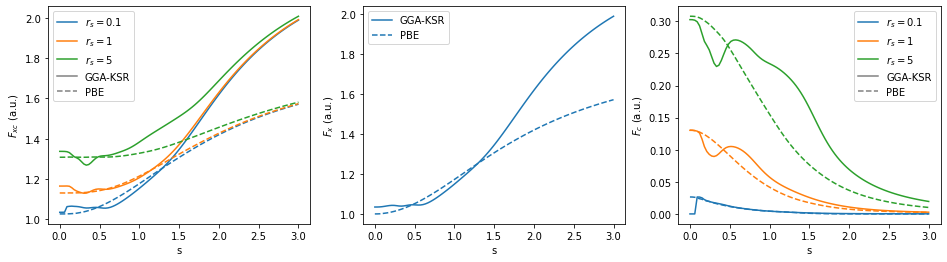

In [8]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe_free/', path='../exp/log_gga_free/2021-02-02_11:41:40.985078_val.chkpt', ueg_limit=False).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base})

## MGGA-KSR(NN)

Loading pre-trained models from ../models/pretrained/scan/
Loading pre-trained models from ../models/pretrained/scan/


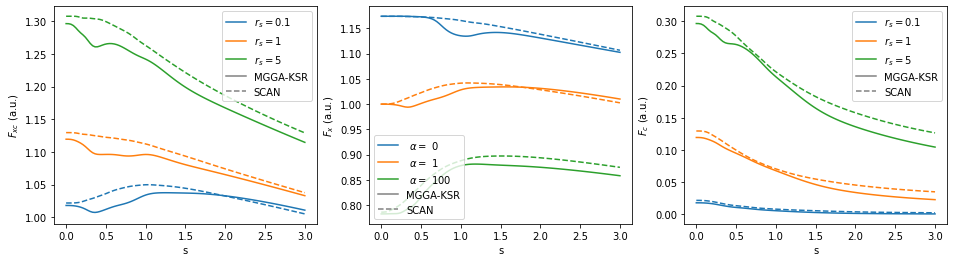

In [9]:
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc = get_scf('MGGA','../models/pretrained/scan/', path='../exp/log_mgga/2021-02-04_22:23:20.359630_val.chkpt', ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base},alpha_range=[0, 1, 100])

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe/


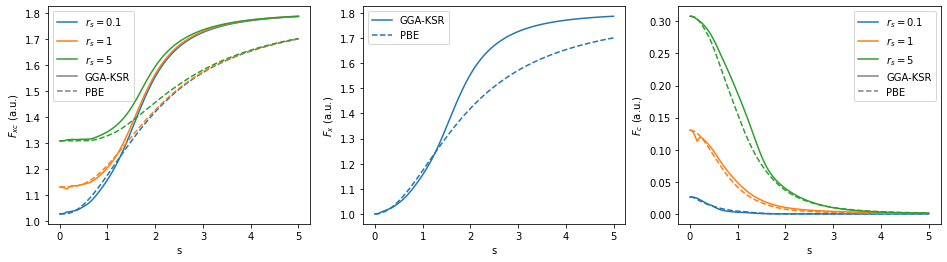

In [16]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga_2/2021-02-08_09:46:52.113037_val.chkpt', ueg_limit=True).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base},s_range=[0,5])

Loading pre-trained models from ../models/pretrained/scan/
Loading pre-trained models from ../models/pretrained/scan_pol/


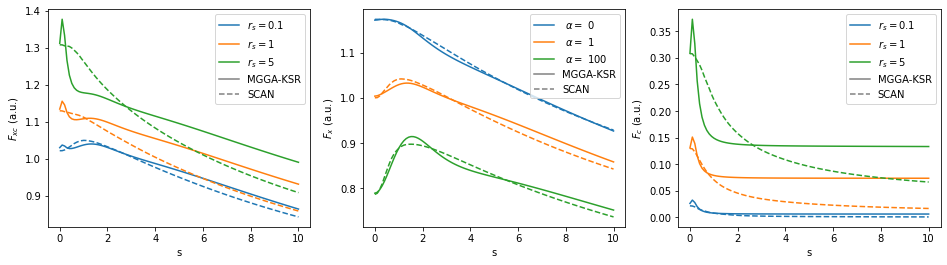

In [12]:
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc = get_scf('MGGA','../models/pretrained/scan_pol/', polynomial=True, ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base},s_range=[0,10], alpha_range=[0, 1, 100])

Loading pre-trained models from ../models/pretrained/pbe_freec/
Loading pre-trained models from ../models/pretrained/pbe_freec/


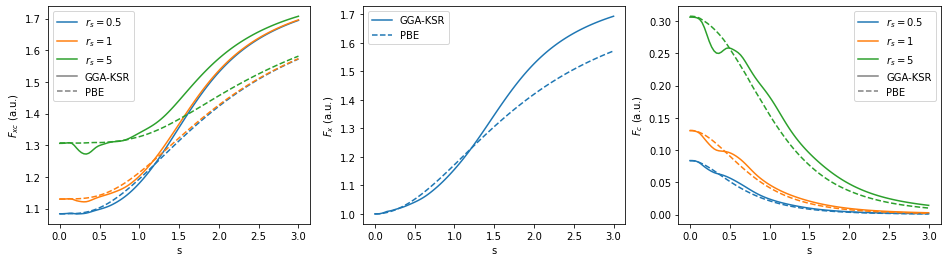

In [21]:
xc_base = get_scf('GGA','../models/pretrained/pbe_freec/',freec=True).xc
xc = get_scf('GGA','../models/pretrained/pbe_freec/', path='../exp/log_gga_freec/2021-02-09_14:33:14.534980_current.chkpt', ueg_limit=True, freec=True).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base},rs =[0.5,1,5], s_range=[0, 3])

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe_pol/


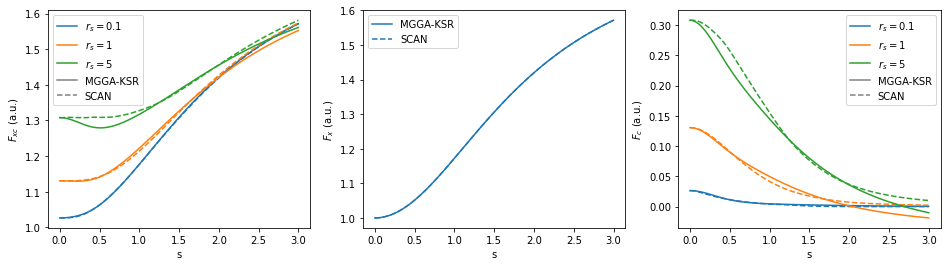

In [7]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe_pol/', polynomial=True, ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base},s_range=[0,3])